In [411]:
import nltk
import numpy as np
from string import punctuation
import re
from keras.preprocessing import text
import pandas as pd
from keras.utils import pad_sequences
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import torch.nn as nn
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings("ignore")

I followed this resource to learn, understand then implement this exercise: https://medium.com/analytics-vidhya/word-embedding-methods-to-generate-them-usage-in-financial-markets-and-experiments-on-twitter-63fae8a5ddd2

In [412]:
drive.mount('/content/drive')
with open('/content/drive/MyDrive/Semester_2/ML Lab/Exercise_08/raw_text.txt', 'r') as file:
    data = [file.read().replace('\n', '')]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [413]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
wpt = WordPunctTokenizer()

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc) # Removing any non-alphabetic characters
    doc = doc.lower().strip() # Converting to lowercase and stripping leading/trailing white spaces
    tokens = wpt.tokenize(doc) # Tokenizing the document
    filtered_tokens = [token for token in tokens if token not in stop_words] # Removing stopwords
    doc = ' '.join(filtered_tokens) # Joining the filtered tokens to form the cleaned document
    doc = doc.replace("\n", " ") # Replacing newlines with whitespaces
    return doc

normalize_corpus = np.vectorize(normalize_document)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [414]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(data)
# Creating a dictionary of word to index mapping
word2id = tokenizer.word_index
# Adding a PAD token to the dictionary
word2id['PAD'] = 0
# Creating a reverse mapping of index to word
id2word = {v:k for k, v in word2id.items()}
# Converting the text to sequences of word indexes
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in alice]
# Calculating the vocabulary size
vocab_size = len(word2id)
# Setting the embedding size
embed_size = 100
# Setting the window size for context words
window_size = 2 


In [415]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    X, Y = [], []
    # Calculating the context length 
    context_length = window_size*2
    # Iterating over the words in corpus
    for words in corpus:
        # Getting the sentence length
        sentence_length = len(words)
        # Iterating over the words in the sentence
        for index, word in enumerate(words):
            # Calculating the start and end index of the context window
            start = index - window_size
            end = index + window_size + 1
            # Selecting the context words
            context = [words[i] for i in range(start, end) if 0 <= i < sentence_length and i != index]
            # Padding the context to the context length
            x = pad_sequences([context], maxlen=context_length)
            # Appending the context words to X
            X.append(x)
            # Appending the target word to Y
            Y.append(word)
    return X, Y


In [416]:
class CBOW(torch.nn.Module):

    def __init__(self, inp_size , vocab_size, embedding_dim=100):
        # Inheriting properties from parent class
        super(CBOW, self).__init__()
        # Creating an embedding layer with the given vocabulary size and embedding dimension
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Creating a fully connected layer with 128 hidden units
        self.linear1 = nn.Linear(embedding_dim, 128)
        # Creating a ReLU activation function
        self.activation_function1 = nn.ReLU()
        # Creating a fully connected layer with the vocabulary size as the output size
        self.linear2 = nn.Linear(128, vocab_size)
        # Creating a LogSoftmax activation function
        self.activation_function2 = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):
        # Summing the embeddings of the input words
        embeds = sum(self.embeddings(torch.from_numpy(inputs).long())).view(1,-1)
        # Feeding the summed embeddings through the first linear layer
        out = self.linear1(embeds)
        # Applying the ReLU activation function
        out = self.activation_function1(out)
        # Feeding the output through the second linear layer
        out = self.linear2(out)
        # Applying the LogSoftmax activation function
        out = self.activation_function2(out)
        # Returning the output
        return out

# Initializing the model with the window size * 2 as input size, and the vocabulary size as the output size
model = CBOW(window_size*2,vocab_size)
# Defining the negative log likelihood loss function
loss_function = nn.NLLLoss()
# Defining the stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [417]:
for epoch in range(1, 50):
    # Initializing the loss variable
    loss = 0.
    # Initializing the index variable
    i = 0
    # Generating context-word pairs for the current epoch
    X,Y = generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size)
    # Iterating over the input-target pairs
    for x, y in zip(X,Y):
        i += 1
        # Zeroing the gradients of the optimizer
        optimizer.zero_grad()
        # Getting the log probabilities of the target word from the model
        log_probs = model(x[0])
        # Calculating the loss between the log probabilities and the target word
        loss = loss_function(log_probs,torch.Tensor([y]).long())
        # Backpropagating the gradients
        loss.backward()
        # Updating the model parameters
        optimizer.step()
        # Accumulating the loss
        loss += loss.data
    # Printing the loss every 10 epochs
    if epoch % 10 == 0:
      print('Epoch:', epoch, 'Loss:', np.round(loss.item(),3))


Epoch: 10 Loss: 7.121
Epoch: 20 Loss: 3.339
Epoch: 30 Loss: 1.26
Epoch: 40 Loss: 0.661


Total words: 30 Word Embedding length: 30


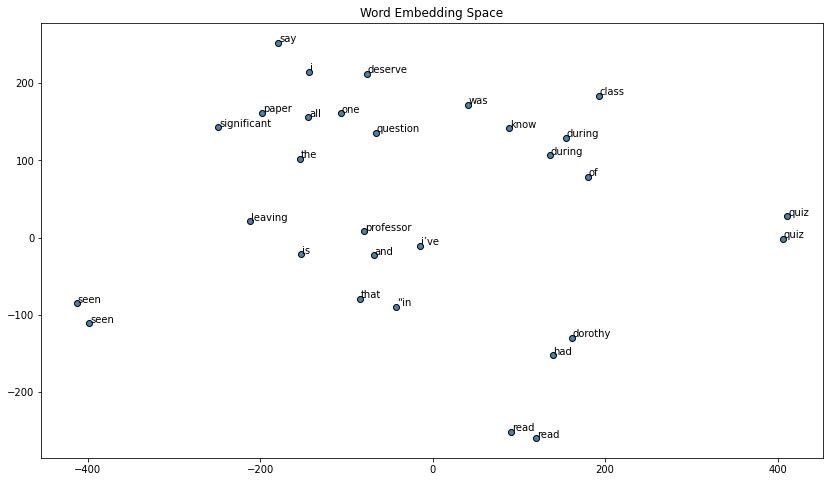

In [420]:
# Create a tensor of integers from 0 to vocab_size-1
vocab_tensor = torch.Tensor([list(range(0,vocab_size))]).long()
# Pass the vocab tensor through the embedding layer to get the weights
weights = model.embeddings(vocab_tensor)
# Reshape the weights to 2D
weights = weights.view(-1,100)
# Calculate the euclidean distance between all the word embeddings
distance_matrix = euclidean_distances(weights.detach().numpy())
# For each search term, find the 5 closest words based on their embeddings
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] for search_term in ['the','i','was','and','of'] }
# Concatenate search terms and their similar words into a single list of words
words = sum([[k] + v for k, v in similar_words.items()], [])
# Get the ids of the words
words_ids = [word2id[w] for w in words]
# Get the embedding vectors of the words
word_vectors = ([weights[idx].detach().numpy() for idx in words_ids])
# Print the total number of words and their embedding shapes
print('Total words:', len(words), 'Word Embedding length:', len(word_vectors))
# Apply t-SNE to reduce the dimensions of the word embeddings to 2D
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words
# Plot the word embeddings in a scatter plot
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
# Label each point with the corresponding word
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
plt.title('Word Embedding Space')
plt.show()
